<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/03_action_recognition_ST_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ST-GCNによる動作認識

---



#骨格データからの動作認識

---



骨格データからの動作認識を行います.  
動作認識は, その人が何の動作(投げる, 蹴る, ジャンプ...)をしているかを認識するタスクです.  
動作認識には,画像などから行う手法もありますが,ここでは骨格データを使います.

###骨格データ

骨格データとは，フレームごとの関節座標です.  
しかしながら,素のデータはただの座標であり, グラフとは言えません.  

人間の構造は関節と関節の繋がりで表現できます.つまり人間はグラフとして表現できます.

ノードの特徴（座標）とエッジ（関節の繋がり）を使うことで，骨格データをグラフとして表現します.  
グラフで表現することで,関節間の関係性を考慮することができます.

グラフで表現した骨格データをGraph Convolutional Networks(GCN)に通して, 何の動作をしているかを認識します.

下の動画が，グラフ表現をした骨格データの例です.



<!--
<img src='https://drive.google.com/uc?id=1WrYd80u9buVcmBnpsgSZnzFlsYMih7Nr' width=30%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/03_throw_skeleton.gif?raw=true' width=30%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/03_throw_skeleton.gif?raw=true' width=30%>

#Spatial Temporal Graph Convolutional Networks

---



GCNを使った骨格データからの動作認識の代表的な手法として, Spatial Temporal Graph Convolutional Networks(ST-GCN)[[arXiv](https://arxiv.org/abs/1801.07455)]があります.

<!--
<img src='https://drive.google.com/uc?id=1ZRf-NF4S0P1VwMxN2DrTFPeO4EJ5if3S' width=100%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/03_st-gcn.png?raw=true' width=100%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/03_st-gcn.png?raw=true' width=100%>

ST-GCNの特徴は,骨格データを2つのグラフ構造として表現したことです.
- 空間グラフ：同一フレーム内の関節を結ぶグラフ　
- 時間グラフ：隣接フレームの同一関節を結ぶグラフ

空間グラフと時間グラフをGraph Covnolutionによって特徴を抽出することで，関節間の関係と, 時間的な変化を考慮しています. 

<!--
<img src='https://drive.google.com/uc?id=1FDOGPZxaIYs-be-6tZzPeBsrtMcBXcuv' width=30%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/03_st_graph.png?raw=true' width=30%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/03_st_graph.png?raw=true' width=30%>

# 実装前の準備

---




必要なモジュールのインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

GPU確認　　

今回からGPUを使用して学習します. 確認してください.

In [2]:
print('Use CUDA:', torch.cuda.is_available())

Use CUDA: True


シード値固定

In [3]:
seed = 123
# Numpy
np.random.seed(seed)
# Pytorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

# データセット

---


データセットをダンロードします.今回は，小さな独自のデータセット(注1)を用意したので，それを使用します.  
動作クラス数は10クラス（0~9）です.動作は以下の通りです.
*   0:　飲む
*   1:　投げる
*   2:　座る
*   3:　立ち上がる
*   4:　拍手
*   5:　手を振る
*   6:　蹴る
*   7:　ジャンプ
*   8:　敬礼
*   9:　転倒







注1: このデータセットは[NTU-RGB+Dデータセット](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Shahroudy_NTU_RGBD_A_CVPR_2016_paper.pdf)を利用して作成しました.  
Portions of the research used the NTU RGB+D Action Recognition Dataset made available by the ROSE Lab at the Nanyang Technological University, Singapore.

In [4]:
!wget -q http://mprg.cs.chubu.ac.jp/~itaya/share/mprg_colab/NTU-RGBD_data/data.zip
!unzip -q -o data.zip

学習データ数が2000(10クラス×200データ), 評価データ数が200(10クラス×20データ)あります.

データの構造を確認します.


In [5]:
test_data = np.load("data/test_data.npy")
print(test_data[0].shape)

(3, 80, 25)


(次元数，フレーム数，関節数)の構造です.  
1データあたり,3次元座標の25関節が80フレーム分入っています.

In [6]:
# データを読み込むための関数
class Feeder(torch.utils.data.Dataset):
  def __init__(self, data_path, label_path):
      super().__init__()
      self.label = np.load(label_path)
      self.data = np.load(data_path)

  def __len__(self):
      return len(self.label)

  def __iter__(self):
      return self

  def __getitem__(self, index):
      data = np.array(self.data[index])
      label = self.label[index]

      return data, label

### 隣接行列を作成

今は座標データ（ノード特徴）しかないため，グラフではありません．  
接続関係を定義して，グラフにします．接続関係の表現には隣接行列を使用します.  
class化しておきます. モデルの定義する際に呼び出します.

隣接行列を手作業で編集するのは大変であるため，接続関係を配列で用意し，それをもとに隣接行列を作ります.

In [7]:
class Graph():
  def __init__(self, hop_size):
    # エッジ配列を宣言します. 集合としては{{始点, 終点}, {始点, 終点}, {始点, 終点}...}のように一つのエッジを要素として宣言します.
    self.get_edge()
    
    # hop: hop数分離れた関節を結びます.
    # 例えばhop=2だと, 手首は肘だけではなく肩にも繋がっています.
    self.hop_size = hop_size 
    self.hop_dis = self.get_hop_distance(self.num_node, self.edge, hop_size=hop_size)

    # 隣接行列を作ります.ここではhop数ごとに隣接行列を作成します.
    # hopが2の時, 0hop, 1hop, 2hopの３つの隣接行列が作成されます.
    # 複数の生成方法が論文中に提案されています. 今回はわかりやすいものを使いました.
    self.get_adjacency() 

  def __str__(self):
    return self.A

  def get_edge(self):
    self.num_node = 25
    self_link = [(i, i) for i in range(self.num_node)] # ループ
    neighbor_base = [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21),
                      (6, 5), (7, 6), (8, 7), (9, 21), (10, 9),
                      (11, 10), (12, 11), (13, 1), (14, 13), (15, 14),
                      (16, 15), (17, 1), (18, 17), (19, 18), (20, 19),
                      (22, 23), (23, 8), (24, 25), (25, 12)]
    neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_base]
    self.edge = self_link + neighbor_link

  def get_adjacency(self):
    valid_hop = range(0, self.hop_size + 1, 1)
    adjacency = np.zeros((self.num_node, self.num_node))
    for hop in valid_hop:
        adjacency[self.hop_dis == hop] = 1
    normalize_adjacency = self.normalize_digraph(adjacency)
    A = np.zeros((len(valid_hop), self.num_node, self.num_node))
    for i, hop in enumerate(valid_hop):
        A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis == hop]
    self.A = A

  def get_hop_distance(self, num_node, edge, hop_size):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(hop_size + 1)]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(hop_size, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis

  def normalize_digraph(self, A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    DAD = np.dot(A, Dn)
    return DAD

#ST-GCN実装

---



###空間グラフの畳み込み  

まずは，空間グラフ(人間の接続パターン)のグラフ畳み込みを実装します.  
式は前回(Graph Convolutional Networksによるノード分類)に示したGraph Convolutionとほぼ同じです.
\begin{equation}
{\bf H}_{out}=\sum_{j}{\bf\tilde D}^{-\frac{1}{2}}_j{\bf\tilde A}_j{\bf\tilde D}^{-\frac{1}{2}}_j{\bf H}_{in}{\bf W}_{j}
\end{equation}
hop数分の隣接行列($j$:隣接行列の数)があるため，各隣接行列で畳み込んでから，特徴を足し合わせています.  

高速化や，今後の拡張性のため，前回のGCとは実装を変えています.


In [8]:
class SpatialGraphConvolution(nn.Module):
  def __init__(self, in_channels, out_channels, s_kernel_size):
    super().__init__()
    self.s_kernel_size = s_kernel_size
    self.conv = nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels * s_kernel_size,
                          kernel_size=1)
    
  def forward(self, x, A):
    x = self.conv(x)
    n, kc, t, v = x.size()
    x = x.view(n, self.s_kernel_size, kc//self.s_kernel_size, t, v)
    # 隣接行列にGCを行い, 特徴を足し合わせています.
    x = torch.einsum('nkctv,kvw->nctw', (x, A))
    return x.contiguous()

###時間グラフの畳み込み

時間グラフは,グラフ畳み込み処理ではなく一般的な2d畳み込み処理で実装できます.  
特徴マップは（フレーム数×関節数)の形になっています. 同一関節をフレーム方向に繋いだものが時間グラフです.  
フレーム方向に畳み込めばいいため（$T\times 1$）の2d畳み込みフィルターで実装できます.

また, ST-GCNは, 空間グラフと時間グラフの畳み込みを交互に行います.  
これを繰り返すので, 空間グラフと時間グラフ，その他(活性化関数やdropout)を備えたクラス(STGC_block)を作っておきます.

In [9]:
class STGC_block(nn.Module):
  def __init__(self, in_channels, out_channels, stride, t_kernel_size, A_size, dropout=0.5):
    super().__init__()
    # 空間グラフの畳み込み
    self.sgc = SpatialGraphConvolution(in_channels=in_channels,
                                       out_channels=out_channels,
                                       s_kernel_size=A_size[0])
    
    # Learnable weight matrix M エッジに重みを与えます. どのエッジが重要かを学習します.
    self.M = nn.Parameter(torch.ones(A_size))

    self.tgc = nn.Sequential(nn.BatchNorm2d(out_channels),
                            nn.ReLU(),
                            nn.Dropout(dropout),
                            nn.Conv2d(out_channels,
                                      out_channels,
                                      (t_kernel_size, 1),
                                      (stride, 1),
                                      ((t_kernel_size - 1) // 2, 0)),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())

  def forward(self, x, A):
    x = self.tgc(self.sgc(x, A * self.M))
    return x

###ネットワークモデル

In [10]:
class ST_GCN(nn.Module):
  def __init__(self, num_classes, in_channels, t_kernel_size, hop_size):
    super().__init__()
    # グラフ作成
    graph = Graph(hop_size)
    A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
    self.register_buffer('A', A)
    A_size = A.size()
  
    # Batch Normalization
    self.bn = nn.BatchNorm1d(in_channels * A_size[1])
    
    # STGC_blocks
    self.stgc1 = STGC_block(in_channels, 32, 1, t_kernel_size, A_size)
    self.stgc2 = STGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc3 = STGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc4 = STGC_block(32, 64, 2, t_kernel_size, A_size)
    self.stgc5 = STGC_block(64, 64, 1, t_kernel_size, A_size)
    self.stgc6 = STGC_block(64, 64, 1, t_kernel_size, A_size)

    # Prediction
    self.fc = nn.Conv2d(64, num_classes, kernel_size=1)

  def forward(self, x):
    # Batch Normalization
    N, C, T, V = x.size() # batch, channel, frame, node
    x = x.permute(0, 3, 1, 2).contiguous().view(N, V * C, T)
    x = self.bn(x)
    x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()

    # STGC_blocks
    x = self.stgc1(x, self.A)
    x = self.stgc2(x, self.A)
    x = self.stgc3(x, self.A)
    x = self.stgc4(x, self.A)
    x = self.stgc5(x, self.A)
    x = self.stgc6(x, self.A)

    # Prediction
    x = F.avg_pool2d(x, x.size()[2:])
    x = x.view(N, -1, 1, 1)
    x = self.fc(x)
    x = x.view(x.size(0), -1)
    return x

#モデルの学習

---



In [11]:
NUM_EPOCH = 100
BATCH_SIZE = 64

# モデルを作成
model = ST_GCN(num_classes=10, 
                  in_channels=3,
                  t_kernel_size=9, # 時間グラフ畳み込みのカーネルサイズ (t_kernel_size × 1)
                  hop_size=2).cuda()

# オプティマイザ
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 誤差関数
criterion = torch.nn.CrossEntropyLoss()

# データセットの用意
data_loader = dict()
data_loader['train'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/train_data.npy', label_path='data/train_label.npy'), batch_size=BATCH_SIZE, shuffle=True,)
data_loader['test'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/test_data.npy', label_path='data/test_label.npy'), batch_size=BATCH_SIZE, shuffle=False)

# モデルを学習モードに変更
model.train()

# 学習開始
for epoch in range(1, NUM_EPOCH+1):
  correct = 0
  sum_loss = 0
  for batch_idx, (data, label) in enumerate(data_loader['train']):
    data = data.cuda()
    label = label.cuda()

    output = model(data)

    loss = criterion(output, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()
    _, predict = torch.max(output.data, 1)
    correct += (predict == label).sum().item()

  print('# Epoch: {} | Loss: {:.4f} | Accuracy: {:.4f}'.format(epoch, sum_loss/len(data_loader['train'].dataset), (100. * correct / len(data_loader['train'].dataset))))

# Epoch: 1 | Loss: 0.0359 | Accuracy: 15.0500
# Epoch: 2 | Loss: 0.0345 | Accuracy: 20.4000
# Epoch: 3 | Loss: 0.0338 | Accuracy: 23.2000
# Epoch: 4 | Loss: 0.0328 | Accuracy: 26.1500
# Epoch: 5 | Loss: 0.0313 | Accuracy: 29.5000
# Epoch: 6 | Loss: 0.0298 | Accuracy: 32.7000
# Epoch: 7 | Loss: 0.0284 | Accuracy: 36.7500
# Epoch: 8 | Loss: 0.0269 | Accuracy: 40.7000
# Epoch: 9 | Loss: 0.0247 | Accuracy: 46.1500
# Epoch: 10 | Loss: 0.0216 | Accuracy: 53.3500
# Epoch: 11 | Loss: 0.0195 | Accuracy: 56.3500
# Epoch: 12 | Loss: 0.0178 | Accuracy: 59.3500
# Epoch: 13 | Loss: 0.0175 | Accuracy: 60.5500
# Epoch: 14 | Loss: 0.0177 | Accuracy: 58.2000
# Epoch: 15 | Loss: 0.0165 | Accuracy: 61.4000
# Epoch: 16 | Loss: 0.0163 | Accuracy: 63.3000
# Epoch: 17 | Loss: 0.0155 | Accuracy: 64.7000
# Epoch: 18 | Loss: 0.0147 | Accuracy: 66.6000
# Epoch: 19 | Loss: 0.0142 | Accuracy: 68.2500
# Epoch: 20 | Loss: 0.0140 | Accuracy: 68.9500
# Epoch: 21 | Loss: 0.0137 | Accuracy: 70.5000
# Epoch: 22 | Loss: 0.

#モデルの評価

---



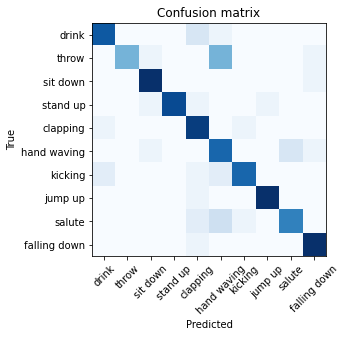

# Test Accuracy: 80.000[%]


In [12]:
# モデルを評価モードに変更
model.eval()

correct = 0
confusion_matrix = np.zeros((10, 10))
with torch.no_grad():
  for batch_idx, (data, label) in enumerate(data_loader['test']):
    data = data.cuda()
    label = label.cuda()

    output = model(data)

    _, predict = torch.max(output.data, 1)
    correct += (predict == label).sum().item()

    for l, p in zip(label.view(-1), predict.view(-1)):
      confusion_matrix[l.long(), p.long()] += 1

len_cm = len(confusion_matrix)
for i in range(len_cm):
    sum_cm = np.sum(confusion_matrix[i])
    for j in range(len_cm):
        confusion_matrix[i][j] = 100 * (confusion_matrix[i][j] / sum_cm)

classes = ['drink', 'throw', 'sit down', 'stand up', 'clapping', 'hand waving', 'kicking', 'jump up', 'salute', 'falling down']
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.tight_layout()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()


print('# Test Accuracy: {:.3f}[%]'.format(100. * correct / len(data_loader['test'].dataset)))

#課題

骨格データに対するグラフ構造を変えて, ネットワークを学習してみましょう.

骨格パターンによるグラフ構造は, 論文著者よる設計であり, それに従う必要はありません.  
グラフ構造は自由な設計が許されています.  
当然， 手と足など離れた関節を結んでも何の問題もありません.

そこで, 自由にグラフ構造を設計し認識精度が上がるようなグラフ構造を発見してみましょう.  
離れた関節を結んだり, エッジの数を増やすなど様々なグラフ構造が考えられます.

`class Graph`の`neighbor_base = [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21),
                      (6, 5), (7, 6), (8, 7), (9, 21), (10, 9),
                      (11, 10), (12, 11), (13, 1), (14, 13), (15, 14),
                      (16, 15), (17, 1), (18, 17), (19, 18), (20, 19),
                      (22, 23), (23, 8), (24, 25), (25, 12)]`を変更することでグラフ構造を変えることができます.

関節と関節の番号は以下の通りです.

<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/03_skeleton.png?raw=true' width=30%>